# Introduction

This files contains sollutions for all 3 tasks.  

I decided on performing task 2 first. It involves a exploratory analysis which I needed to perform anyway. It helped me understend the data better for the other tasks. Then I focused on semantic analysis, after finishing task 3 I went back and enchanced my analysis for task 2 with the new knowledge. Finally I did task 1 last. That's because I wanted to leverage the information I gained from task 2 & 3 for creating better models.

**Table of Contents**
* [Environment Setup](#chapter1)
* [Task 2 - Exploratory Data Analyis](#chapter2)
    * [Importing Data](#section_2_1)
    * [Exploring, Cleaning and Preprocessing Data](#section_2_2)
        * [Exploring Orders](#sub_section_2_2_1)
        * [Exploring Geolocations](#sub_section_2_2_2)
        * [Exploring Sellers](#sub_section_2_2_3)
        * [Exploring Products](#sub_section_2_2_4)
        * [Exploring Customers](#sub_section_2_2_5)
        * [Preparing Analysis DataFrame](#sub_section_2_2_6)
    * [Analysis of Sellers](#section_2_3)
    * [Analysis of Product Categories](#section_2_4)
* [Task 3 - Sentimental Analysis of Reviews](#chapter3)
    * [Exploring Review Data](#section_3_1)
    * [Sentimental Analysis of Reviews](#section_3_2)
* [Task 1 - Demand Forcasting](#chapter4)
    * [Statistical forecasting with ARIMA](#section_4_1)
    * [Forcasting with XGBoost](#section_4_2)

# Environment Setup <a class="anchor" id="chapter1"></a>

In this section I install necessary packages, import and setup them. Then I import zipped data file and parse it.

In [2]:
%pip install seaborn thefuzz unidecode geopy nltk transformers matplotlib basemap xgboost pytorch statsmodels scikit-learn pandas numpy

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-wftr2ocx/pytorch_767cea40aeca42dfaba948c8cb633568/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import zipfile
import torch
import ast
import nltk
from unidecode import unidecode
import geopy.distance
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


In [4]:
sns.color_palette("ocean")
sns.set_style("darkgrid")

The next 3 code cells are only usefull for unziping the data file for the first time.

In [5]:
# # Open the zipped Data.zip file
# with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
#     # Get a list of all files and directories in the zip file
#     file_list = zip_ref.namelist()

#     # Iterate over the list and print each name
#     for name in file_list:
#         print(name)

In [6]:
# # Unpack the Data.zip file
# with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
#     # Extract all files and directories from the zip file to the current directory
#     zip_ref.extractall()

#     # Get a list of all files and directories in the zip file
#     file_list = zip_ref.namelist()

#     # Iterate over the list and print each name
#     for name in file_list:
#         print(name)

In [7]:
# # Unpack the dicts.zip file
# with zipfile.ZipFile('S_Data/dicts.zip', 'r') as zip_ref:
#     # Extract all files and directories from the zip file to the current directory
#     zip_ref.extractall()

#     # Get a list of all files and directories in the zip file
#     file_list = zip_ref.namelist()

#     # Iterate over the list and print each name
#     for name in file_list:
#         print(name)

# Task 2 - Exploratory Data Analyis <a class="anchor" id="chapter2"></a>

## Loading Data <a class="anchor" id="section_2_1"></a>

First I am going to load and inspect the metadata inside dicts.

In [8]:
# Read the dictionary files
with open('dicts/customers_dict.csv', 'r') as file:
    print(file.read())

customer_id;key to the orders dataset. Each order has a unique customer_id
customer_unique_id;unique identifier of a customer.
customer_zip_code_prefix;first five digits of customer zip code
customer_city;customer city name
customer_state;customer state


In [9]:
# Load the data
customers = pd.read_csv('S_Data/customers.csv')
geolocation = pd.read_csv('S_Data/geolocation.csv')
order_items = pd.read_csv('S_Data/order_items.csv')
order_payments = pd.read_csv('S_Data/order_payments.csv')
order_reviews = pd.read_csv('S_Data/order_reviews.csv')
orders = pd.read_csv('S_Data/orders.csv')
products = pd.read_csv('S_Data/products.csv')
sellers = pd.read_csv('S_Data/sellers.csv')
product_category_name_translation = pd.read_csv('S_Data/product_category_name_translation.csv')

## Data Exploration and Processing <a class="anchor" id="section_2_2"></a>

### Inspecting Orders <a class="anchor" id="sub_section_2_2_1"></a>

First I want to inspect the main fact table - orders.

In [10]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [11]:
print(orders.info())
print("Unique values in orders:")
print(orders.nunique())
print("Empty values in orders:")
print(orders.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None
Unique values in orders:
order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     8101

Format date columns as dates

In [12]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

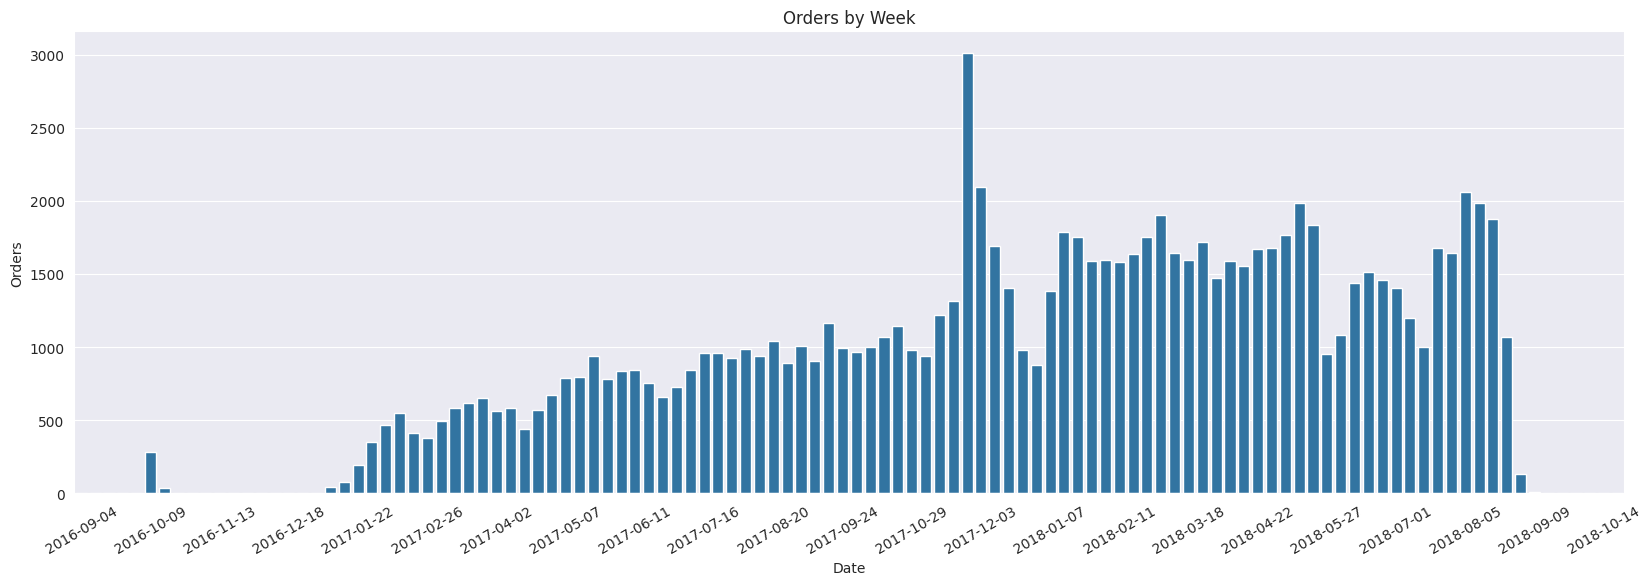

In [13]:
daily_orders = orders.resample('W', on='order_purchase_timestamp')['order_id'].count().reset_index()
plt.figure(figsize=(20, 6))
sns.barplot(x='order_purchase_timestamp', y='order_id', data=daily_orders)
plt.xlabel('Date')
xticks_locs, _= plt.xticks()
plt.xticks(xticks_locs[::5])
plt.xticks(rotation=30)
plt.ylabel('Orders')
plt.title('Orders by Week')
plt.show()

In [14]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [15]:
print(order_items.info())
print("Unique values in order_items:")
print(order_items.nunique())
print("Empty values in order_items:")
print(order_items.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None
Unique values in order_items:
order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64
Empty values in order_items:
order_id               0
order_item_id          0
product_id             0
seller_id     

In [16]:
print(order_items['order_item_id'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


Check weekly, monthly, quaterly and yearly seasonality.

In [17]:
# # Weekly seasonality
# weekly_orders = orders.resample('W', on='order_purchase_timestamp')['order_id'].count().reset_index()
# weekly_orders['percentage_change'] = weekly_orders['order_id'].pct_change()
# weekly_orders['percentage_change_shifted'] = weekly_orders['percentage_change'].shift()

# # Monthly seasonality
# monthly_orders = orders.resample('M', on='order_purchase_timestamp')['order_id'].count().reset_index()
# monthly_orders['percentage_change'] = monthly_orders['order_id'].pct_change()
# monthly_orders['percentage_change_shifted'] = monthly_orders['percentage_change'].shift()

# # Quarterly seasonality
# quarterly_orders = orders.resample('Q', on='order_purchase_timestamp')['order_id'].count().reset_index()
# quarterly_orders['percentage_change'] = quarterly_orders['order_id'].pct_change()
# quarterly_orders['percentage_change_shifted'] = quarterly_orders['percentage_change'].shift()

# # Yearly seasonality
# yearly_orders = orders.resample('Y', on='order_purchase_timestamp')['order_id'].count().reset_index()
# yearly_orders['percentage_change'] = yearly_orders['order_id'].pct_change()
# yearly_orders['percentage_change_shifted'] = yearly_orders['percentage_change'].shift()

###  Inspecting Location Data <a class="anchor" id="sub_section_2_2_2"></a>

In [18]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [19]:
print(geolocation.info())
print("Unique values in geolocation:")
print(geolocation.nunique())
print("Empty values in geolocation:")
print(geolocation.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
None
Unique values in geolocation:


geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64
Empty values in geolocation:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64


I notice that locations are duplicated, with diffrence in spelling because of symbols. I transform all city names to unicode for deduplication. The geolocation data has multiple locations for each zipcode but there is no way for me to match each location with a seller or a customer so I will calculate average location for each zipcode.

In [20]:
geolocation['geolocation_city'] = geolocation['geolocation_city'].apply(lambda x: unidecode(x))

In [21]:
avg_geolocation = geolocation.groupby(['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'])[['geolocation_lat', 'geolocation_lng']].mean().reset_index()
avg_geolocation.head()

,geolocation_zip_code_prefix,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
0,1001,sao paulo,SP,-23.550190,-46.634024
1,1002,sao paulo,SP,-23.548146,-46.634979
2,1003,sao paulo,SP,-23.548994,-46.635731
3,1004,sao paulo,SP,-23.549799,-46.634757
4,1005,sao paulo,SP,-23.549456,-46.636733


In [22]:
avg_geolocation.nunique()

geolocation_zip_code_prefix    19015
geolocation_city                5969
geolocation_state                 27
geolocation_lat                19603
geolocation_lng                19602
dtype: int64

### Inspecting Sellers Data <a class="anchor" id="sub_section_2_2_3"></a>

To analyze orders based on data from other tables I am going to create a combined data frame with all data.

In [23]:
# need to apply the same preprocessing as with geolocations to ensure data matches
customers['customer_city'] = customers['customer_city'].apply(lambda x: unidecode(x))
sellers['seller_city'] = sellers['seller_city'].apply(lambda x: unidecode(x))

customers_w_loc = customers.merge(
    avg_geolocation,
    left_on=['customer_zip_code_prefix', 'customer_city', 'customer_state'],
    right_on=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'],
    how='left'
)
customers_w_loc.drop(columns=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'], inplace=True)
customers_w_loc.rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'}, inplace=True)

sellers_w_loc = sellers.merge(
    avg_geolocation, 
    left_on=['seller_zip_code_prefix', 'seller_city', 'seller_state'], 
    right_on=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'], 
    how='left'
)
sellers_w_loc.drop(columns=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'], inplace=True)
sellers_w_loc.rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'}, inplace=True)


combined = orders.merge(order_items, on='order_id')
combined = combined.merge(products, on='product_id')
combined = combined.merge(sellers_w_loc, on='seller_id')
combined = combined.merge(customers_w_loc, on='customer_id')
combined = combined.merge(order_payments, on='order_id')
combined = combined.merge(order_reviews, on='order_id')
print("The data has a shape of: ", combined.shape)
combined.head()

The data has a shape of:  (118315, 43)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,...,1,credit_card,3,37.77,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,...,1,credit_card,1,37.77,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23


In [24]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [25]:
print(sellers.info())
print("Unique values in sellers:")
print(sellers.nunique())
print("Empty values in sellers:")
print(sellers.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
None
Unique values in sellers:
seller_id                 3095
seller_zip_code_prefix    2246
seller_city                609
seller_state                23
dtype: int64
Empty values in sellers:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64


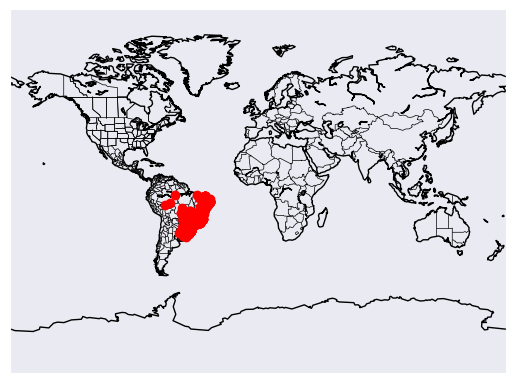

In [26]:
# Create a map centered at an appropriate location
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c')

# Convert latitude and longitude to map projection coordinates
lons, lats = m(sellers_w_loc['seller_lng'].values, sellers_w_loc['seller_lat'].values)

# Plot each data point on the map
m.scatter(lons, lats, marker = 'o', color='r', zorder=5)

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Display the map
plt.show()

The sellers dataframe provides a seller's id and location information including partial zipcode, city and state. There is no missing data. All sellers are based in South America, mostly Brazil.

### Inspecting Products Data <a class="anchor" id="sub_section_2_2_4"></a>

In [27]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [28]:
print(products.info())
print("Unique values in products:")
print(products.nunique())
print("Empty values in products:")
print(products.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
None
Unique values in products:
product_id                    32951
product_category_name            73
product_name_lenght              66
product_description_lenght     2960
product_photos_qty               19
p

In [29]:
products_with_missing_data = products[products['product_category_name'].isna() & products['product_description_lenght'].isna() & products['product_photos_qty'].isna()]['product_id'].values
print("There are {} products with missing data.".format(len(products_with_missing_data)))

There are 610 products with missing data.


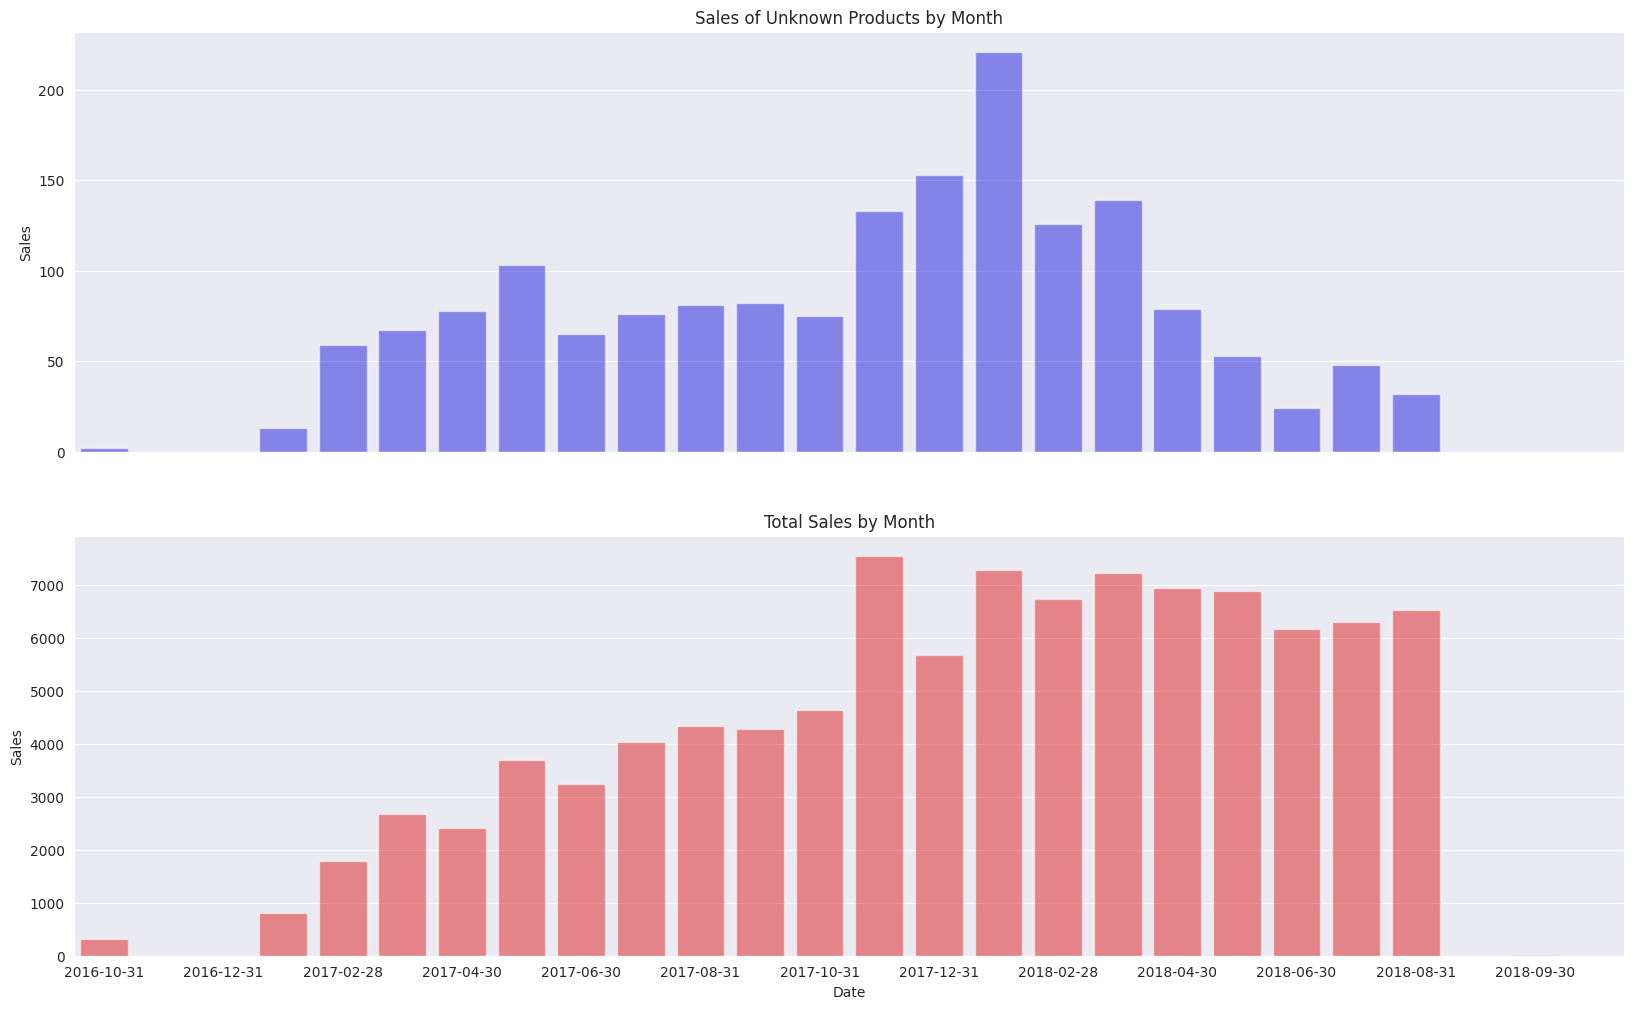

In [30]:
sales_of_unknown_products = combined[combined['product_id'].isin(products_with_missing_data)]
sales_of_unknown_products_by_month = sales_of_unknown_products.resample('M', on='order_purchase_timestamp')['order_id'].count().reset_index()

monthly_orders = orders.resample('M', on='order_purchase_timestamp')['order_id'].count().reset_index()

fig, axs = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

sns.barplot(x='order_purchase_timestamp', y='order_id', data=sales_of_unknown_products_by_month, color='blue', alpha=0.5, ax=axs[0])
sns.barplot(x='order_purchase_timestamp', y='order_id', data=monthly_orders, color='red', alpha=0.5, ax=axs[1])

axs[0].set_title('Sales of Unknown Products by Month')
axs[0].set_ylabel('Sales')
axs[1].set_title('Total Sales by Month')
axs[1].set_ylabel('Sales')
axs[1].set_xlabel('Date')

xtics, _ = plt.xticks()
plt.xticks(xtics[::2])
plt.show()

There are 95 sellers with more than 50% of sales from unknown products.


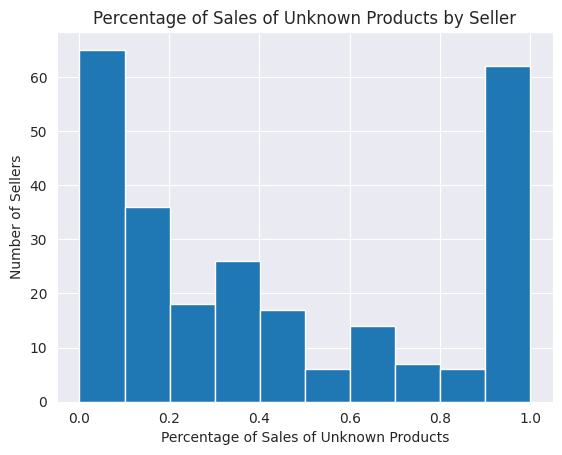

In [31]:
sellers_of_unknown_products = sales_of_unknown_products.groupby('seller_id')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)
sellers_of_unknown_products.rename(columns={'order_id': 'sales_of_unknown_products'}, inplace=True)
sales_of_sellers_of_unknown_products = combined[combined['seller_id'].isin(sellers_of_unknown_products['seller_id'])].groupby('seller_id')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)
sales_of_sellers_of_unknown_products.rename(columns={'order_id': 'total_sales'}, inplace=True)
sellers_of_unknown_products = sellers_of_unknown_products.merge(sales_of_sellers_of_unknown_products, on='seller_id')
sellers_of_unknown_products['percentage_of_unknown_products_sales'] = sellers_of_unknown_products['sales_of_unknown_products'] / sellers_of_unknown_products['total_sales']
sellers_of_unknown_products['percentage_of_unknown_products_sales'].hist(bins=10)
sellers_to_exclude = sellers_of_unknown_products[sellers_of_unknown_products['percentage_of_unknown_products_sales'] > 0.5]['seller_id'].values
plt.xlabel('Percentage of Sales of Unknown Products')
plt.ylabel('Number of Sellers')
plt.title('Percentage of Sales of Unknown Products by Seller')
print("There are {} sellers with more than 50% of sales from unknown products.".format(len(sellers_to_exclude)))

In [32]:
# Inspecting the biggest seller of unknown products in detail
combined[combined['seller_id'] == 'c826c40d7b19f62a09e2d7c5e7295ee2']
combined[combined['seller_id'] == 'c826c40d7b19f62a09e2d7c5e7295ee2']['product_category_name'].value_counts()
combined[combined['seller_id'] == 'c826c40d7b19f62a09e2d7c5e7295ee2']['product_weight_g'].value_counts()

product_weight_g
400.0     202
450.0      65
100.0      54
550.0      32
1350.0     11
300.0       8
800.0       1
1800.0      1
Name: count, dtype: int64

In [33]:
initial_len = combined.shape[0]
orders_with_sellers_to_exclude = combined[combined['seller_id'].isin(sellers_to_exclude)]['order_id'].values.tolist()
orders_with_products_to_exclude = combined[combined['product_id'].isin(products_with_missing_data)]['order_id'].values.tolist()
orders_to_exclue = list(set(orders_with_sellers_to_exclude + orders_with_products_to_exclude))
combined_filtered = combined[~combined['order_id'].isin(orders_to_exclue)].copy()
new_len = combined_filtered.shape[0]
print("Removed {} rows.".format(initial_len - new_len))

Removed 1951 rows.


The top seller of unknown products sold almost exclusively unknown products. If they had the same parmaters as his known product (esports laser), we could mabye impute values. 

The sales of unknown products were not specific to any period in time. They number of those sales doesn't seem to corelate with the overall number of sales. For most sellers unknown products were a minority of their business but there are also some who exclusively sold unknown products. I are going to exclue unknown products from further analysis. We will also exclude sellers whose sales were mostly based on unknown products (>50%). Those products might have been deleted from the store data because they were fradulent. All orders related to those sellers and products will be excluded.

There were 610 products with missing information, 95 sellers with more than 50% of sales from unknown products and 1710 sales of these products. In total 1951 rows were removed.

### Inspecting Customer data <a class="anchor" id="sub_section_2_2_5"></a>

In [34]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [35]:
print(customers.info())
print("Unique values in customers:")
print(customers.nunique())
print("Empty values in customers:")
print(customers.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
Unique values in customers:
customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64
Empty values in customers:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64


<Axes: xlabel='customer_state'>

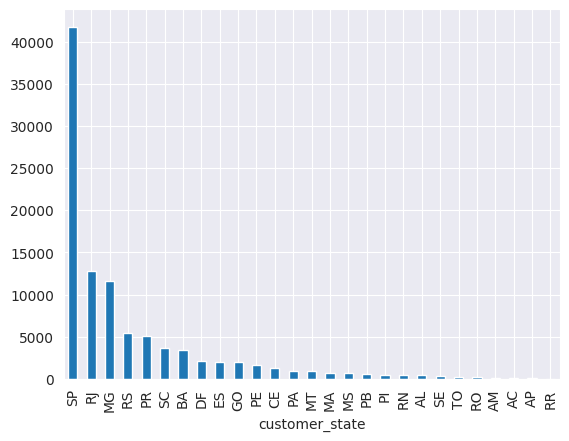

In [36]:
customers['customer_state'].value_counts().plot(kind='bar')

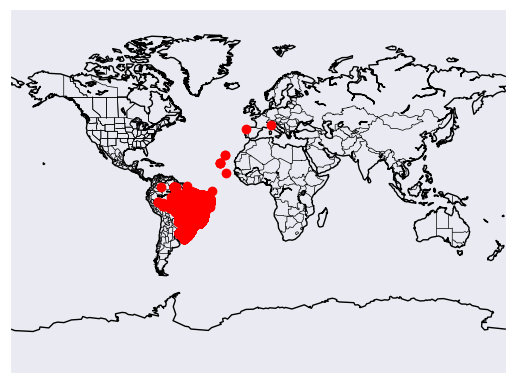

In [37]:
# Create a map centered at an appropriate location
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c')

# Convert latitude and longitude to map projection coordinates
lons, lats = m(customers_w_loc['customer_lng'].values, customers_w_loc['customer_lat'].values)

# Plot each data point on the map
m.scatter(lons, lats, marker = 'o', color='r', zorder=5)

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Display the map
plt.show()

The customer dataset provides an anonysed customer id as well as customer location. Most of the customers are based in Brazil, but there are also some clients from other South American countries and Italy, Portugal, Cape Verde. 

### Preparing Analysis DataFrame <a class="anchor" id="sub_section_2_2_6"></a>

In [38]:
# To judge sellers performance we will only focus on delivered orders
sellers_analysis_df = combined_filtered[combined_filtered['order_status'] == 'delivered'].copy()

# select relevent columns
sellers_analysis_df = sellers_analysis_df[[
    'order_id', 'customer_id',  'order_purchase_timestamp',
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'order_item_id', 'product_id', 'seller_id', 
    'price', 'product_category_name',
    'product_description_lenght',
    'product_photos_qty', 'product_weight_g', 'product_length_cm',
    'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
    'seller_city', 'seller_state', 'seller_lat', 'seller_lng',
    'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
    'customer_state', 'customer_lat', 'customer_lng', 
    'payment_type', 'payment_installments', 'payment_value', 'review_id',
    'review_score']]

# create new columns
sellers_analysis_df['delivery_time'] = sellers_analysis_df['order_delivered_customer_date'] - sellers_analysis_df['order_purchase_timestamp']
sellers_analysis_df['delivery_time'] = sellers_analysis_df['delivery_time'].dt.days

sellers_analysis_df['delay_vs_expected'] = sellers_analysis_df['order_delivered_customer_date'] - sellers_analysis_df['order_estimated_delivery_date']
sellers_analysis_df['delay_vs_expected'] = sellers_analysis_df['delay_vs_expected'].dt.days

sellers_analysis_df['product_volume_cm3'] = sellers_analysis_df['product_length_cm'] * sellers_analysis_df['product_height_cm'] * sellers_analysis_df['product_width_cm']
sellers_analysis_df['product_density_gcm3'] = sellers_analysis_df['product_weight_g'] / sellers_analysis_df['product_volume_cm3']

sellers_analysis_df['payed_in_installments'] = sellers_analysis_df['payment_installments'] > 1
sellers_analysis_df['local_order'] = sellers_analysis_df['seller_state'] + sellers_analysis_df['seller_city'] == sellers_analysis_df['customer_state'] + sellers_analysis_df['customer_city']
sellers_analysis_df['customer_location_id'] = sellers_analysis_df['customer_zip_code_prefix'].astype(str) + sellers_analysis_df['customer_city'] + sellers_analysis_df['customer_state']


distance_function = lambda x : geopy.distance.distance((x['seller_lat'], x['seller_lng']), (x['customer_lat'], x['customer_lng'])).km if not (pd.isnull(x['seller_lat']) or pd.isnull(x['customer_lat'])) else np.nan
sellers_analysis_df['distance'] = sellers_analysis_df.apply(distance_function, axis=1)


In [39]:
# Assuming df is your DataFrame and 'group_column' is the column you want to group by
sales_by_seller = sellers_analysis_df.groupby('seller_id').agg({
    'order_id': 'nunique',                  # count of unique orders
    'customer_unique_id': 'nunique',        # count of unique customers
    'product_id': 'nunique',                # count of unique products sold
    'order_item_id': 'count',               # count of total items sold
    'order_item_id': 'mean',                # average items per order
    'price': ['mean', 'min', 'max'],        # average, min, and max price of sold items
    'product_category_name': 'nunique',     # count of unique product categories
    'product_description_lenght': 'mean',   # average description length
    'product_photos_qty': 'mean',           # average photos per product
    'product_weight_g': 'mean',             # average product weight
    'product_length_cm': 'mean',            # average product length
    'product_height_cm': 'mean',            # average product height
    'product_width_cm': 'mean',             # average product width
    'product_volume_cm3': 'mean',           # average product volume
    'product_density_gcm3': 'mean',         # average product density
    'distance': 'mean',                     # average distance to customer
    'review_score': 'mean',                 # average review score
    'payment_value': 'sum',                 # total payment value
    'payment_installments': 'mean',         # average number of installments
    'payed_in_installments': 'mean',        # percentage of orders payed in installments
    'payment_type': lambda x: x.value_counts().index[0], # most common payment type
    'payment_type': 'nunique',              # count of unique payment types
    'local_order': 'mean',                  # percentage of local orders
    'delivery_time': 'mean',                # average delivery time
    'delay_vs_expected': 'mean',             # average delay vs expected
    'customer_location_id': 'nunique'       # count of unique customer locations
}).reset_index()

sales_by_seller.columns = ['_'.join(col).strip() for col in sales_by_seller.columns.values]
sales_by_seller['total_sales'] = sales_by_seller['order_id_nunique'] * sales_by_seller['price_mean']
sales_by_seller.sort_values(by='total_sales', ascending=False, inplace=True)

sales_by_seller.rename(columns={
    'order_id_nunique': 'total_orders',
    'customer_unique_id_nunique': 'total_customers',
    'product_id_nunique': 'total_products',
    'order_item_id_mean': 'average_items_per_order',
    'price_mean': 'average_price',
    'price_min': 'min_price',
    'price_max': 'max_price',
    'product_category_name_nunique': 'total_product_categories',
    'product_description_lenght_mean': 'average_description_length',
    'product_photos_qty_mean': 'average_photos_per_product',
    'product_weight_g_mean': 'average_product_weight',
    'product_length_cm_mean': 'average_product_length',
    'product_height_cm_mean': 'average_product_height',
    'product_width_cm_mean': 'average_product_width',
    'product_volume_cm3_mean': 'average_product_volume',
    'product_density_gcm3_mean': 'average_product_density',
    'distance_mean': 'average_distance',
    'review_score_mean': 'average_review_score',
    'payment_value_sum': 'total_payment_value',
    'payment_installments_mean': 'average_installments',
    'payed_in_installments_mean': 'percentage_payed_in_installments',
    'payment_type_<lambda>': 'most_common_payment_type',
    'payment_type_nunique': 'total_payment_types',
    'local_order_mean': 'percentage_local_orders',
    'delivery_time_mean': 'average_delivery_time',
    'delay_vs_expected_mean': 'average_delay_vs_expected',
    'customer_location_id_nunique': 'total_customer_locations'
}, inplace=True)
sales_by_seller.head()

,seller_id_,total_orders,total_customers,total_products,average_items_per_order,average_price,min_price,max_price,total_product_categories,average_description_length,...,average_review_score,total_payment_value,average_installments,percentage_payed_in_installments,total_payment_types,percentage_local_orders,average_delivery_time,average_delay_vs_expected,total_customer_locations,total_sales
812,4869f7a5dfa277a7dca6462dcf3b52b2,1124,1117,94,1.031409,199.815390,54.9,899.99,10,522.562818,...,4.112903,261532.48,4.000000,0.710526,4,0.000000,14.744482,-10.985569,1010,224592.498913
956,53243585a1d6dc2643021fd1853d8905,348,340,23,1.222482,561.573630,170.0,1649.99,2,2057.217799,...,4.112412,279843.42,4.662763,0.711944,4,0.000000,12.850117,-11.683841,332,195427.623232
2813,fa1c13f2614d7b5c4749cbc52fecda94,578,575,284,1.013289,333.653372,84.9,3999.90,5,609.194352,...,4.363787,203262.00,4.767442,0.754153,4,0.001661,12.827243,-10.186047,549,192851.649070
836,4a3ca9315b744ce9f8e9374361493884,1771,1758,394,1.142317,100.267220,12.9,884.00,7,329.553664,...,3.802837,300526.26,3.901182,0.625059,4,0.000000,13.805201,-9.658156,1520,177573.246369
1457,7e93a43ef30c4f03f38b393420bc753a,319,319,175,1.011976,516.250868,119.0,1775.00,7,498.245509,...,4.353293,174053.79,5.434132,0.814371,3,0.002994,10.874251,-12.224551,309,164684.026976


In [40]:
top_sellers_by_revenue = sales_by_seller.iloc[:100]
top_sellers_by_volume = sales_by_seller.sort_values(by='total_orders', ascending=False).iloc[:100]

avg_top_seller_by_revenue = top_sellers_by_revenue.drop('seller_id_', axis=1).mean().to_frame()
avg_top_seller_by_volume = top_sellers_by_volume.drop('seller_id_', axis=1).mean().to_frame()
avg_seller = sales_by_seller.drop('seller_id_', axis=1).mean().to_frame()
sellers_above_50_orders = sales_by_seller[sales_by_seller['total_orders'] > 50].drop('seller_id_', axis=1).mean().to_frame()
seller_below_10_orders = sales_by_seller[sales_by_seller['total_orders'] < 10].drop('seller_id_', axis=1).mean().to_frame()

seller_profiles = pd.concat([avg_seller, avg_top_seller_by_revenue, avg_top_seller_by_volume, sellers_above_50_orders, seller_below_10_orders], axis=1)
seller_profiles.columns = ['Average Seller', '100 Top Sellers by Revenue', '100 Top Sellers by Volume', 'Sellers with more than 50 Orders', 'Sellers with less than 10 Orders']
seller_profiles = seller_profiles.T
seller_profiles

,total_orders,total_customers,total_products,average_items_per_order,average_price,min_price,max_price,total_product_categories,average_description_length,average_photos_per_product,...,average_review_score,total_payment_value,average_installments,percentage_payed_in_installments,total_payment_types,percentage_local_orders,average_delivery_time,average_delay_vs_expected,total_customer_locations,total_sales
Average Seller,33.453440,33.136206,11.458652,1.162292,179.077791,112.101324,341.287380,2.121960,868.339566,2.262689,...,4.144733,6811.377067,3.149911,0.519033,2.191105,0.058045,11.655481,-12.314780,32.169562,4116.575542
100 Top Sellers by Revenue,372.690000,367.920000,80.810000,1.126949,305.407933,106.917400,1051.101300,5.060000,964.913837,2.208760,...,4.097577,85752.673300,3.794310,0.593016,3.720000,0.026773,12.657253,-12.367512,346.560000,54581.325585
100 Top Sellers by Volume,440.910000,435.520000,94.460000,1.146795,115.155881,29.419300,605.043700,5.930000,800.610989,2.183390,...,4.061043,78203.773500,2.858871,0.499549,3.940000,0.044932,12.257440,-11.976266,411.430000,46925.377663
Sellers with more than 50 Orders,177.744472,175.909091,48.562654,1.174601,120.723373,35.807543,465.091425,4.488943,812.868393,2.253185,...,4.093709,32855.515848,2.941259,0.501685,3.687961,0.051978,11.875340,-12.296135,169.248157,19603.060990
Sellers with less than 10 Orders,3.436823,3.421781,2.562575,1.159304,201.461969,155.128075,272.409194,1.377858,878.723355,2.279726,...,4.163942,1124.503039,3.232489,0.525092,1.548736,0.060391,11.636029,-12.289402,3.420578,632.207102


## Analysing Sellers <a class="anchor" id="section_2_3"></a>

/tmp/ipykernel_2808/2542190404.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seller_profiles.index, y='returning_customers', data=seller_profiles, palette='ocean')


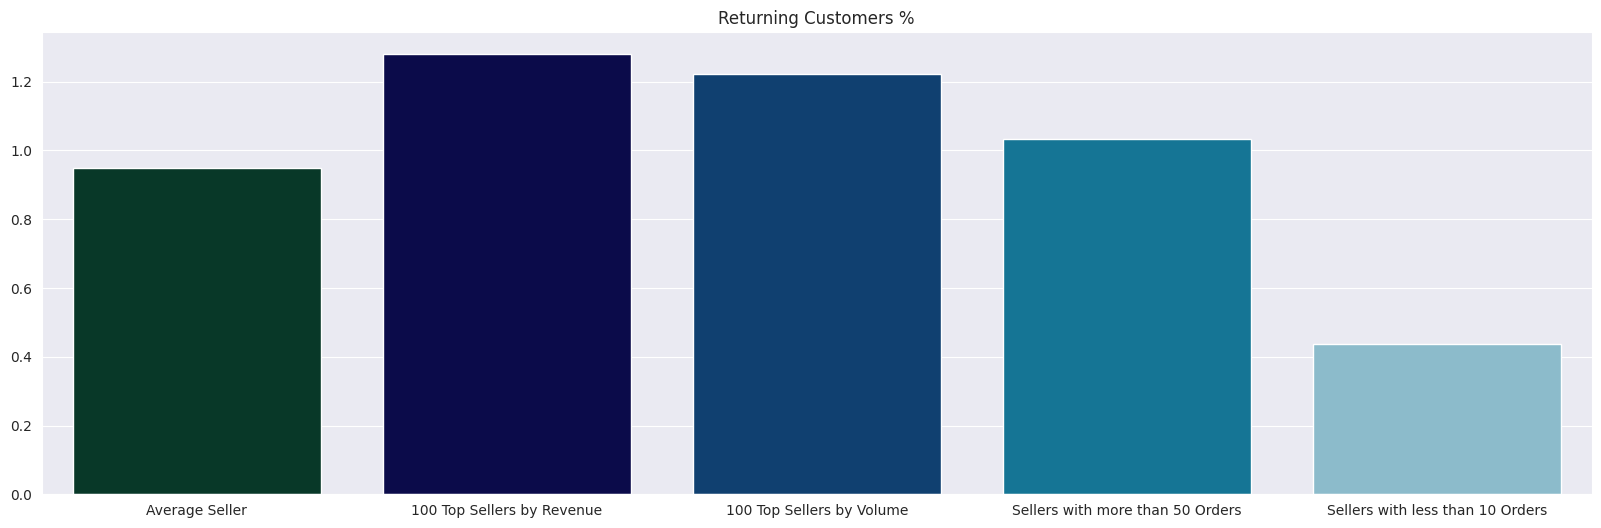

In [41]:
seller_profiles['returning_customers'] = (1- seller_profiles['total_customers'] / seller_profiles['total_orders'] ) * 100
plt.figure(figsize=(20, 6))
sns.barplot(x=seller_profiles.index, y='returning_customers', data=seller_profiles, palette='ocean')
plt.title('Returning Customers %')
plt.ylabel('')
plt.xlabel('')
plt.show()

Customers don't make multiple purcheses with the same sellers. 

/tmp/ipykernel_2808/1100323204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seller_profiles.index, y='average_review_score', data=seller_profiles, palette='ocean')


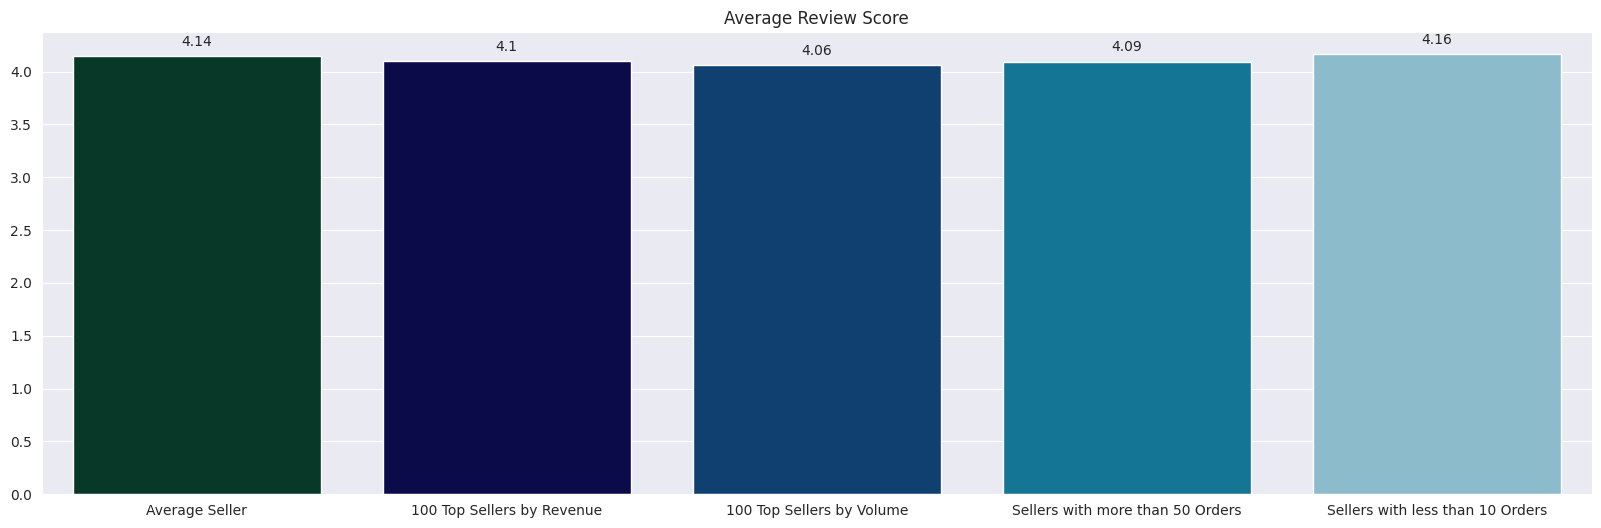

In [42]:
plt.figure(figsize=(20, 6))
sns.barplot(x=seller_profiles.index, y='average_review_score', data=seller_profiles, palette='ocean')
for i, v in enumerate(seller_profiles['average_review_score']):
    plt.text(i, v + 0.1, str(round(v, 2)), ha='center')
plt.title('Average Review Score')
plt.ylabel('')
plt.xlabel('')
plt.show()

Average review score for the top sellers is lower than for average and small sellers meaning that positive reviews might not translate to higher sales.


/tmp/ipykernel_2808/984814311.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seller_profiles.index, y='average_price', data=seller_profiles, palette='ocean')
/tmp/ipykernel_2808/984814311.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_price = seller_profiles['min_price'][i]
/tmp/ipykernel_2808/984814311.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_price = seller_profiles['max_price'][i]


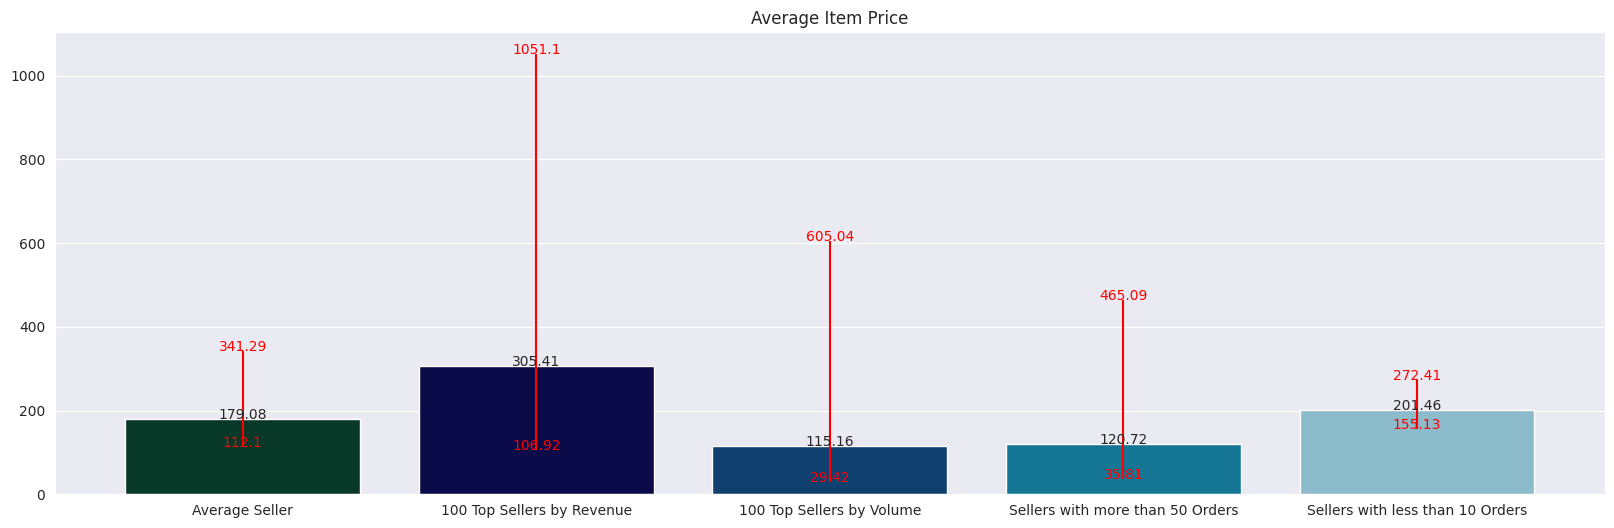

In [43]:
# price distribution
plt.figure(figsize=(20, 6))
sns.barplot(x=seller_profiles.index, y='average_price', data=seller_profiles, palette='ocean')
for i, v in enumerate(seller_profiles['average_price']):
    plt.text(i, v + 0.1, str(round(v, 2)), ha='center')
    min_price = seller_profiles['min_price'][i]
    max_price = seller_profiles['max_price'][i]
    plt.text(i, min_price - 0.1, str(round(min_price, 2)), ha='center', color='red')
    plt.text(i, max_price + 0.1, str(round(max_price, 2)), ha='center', color='red')
    plt.vlines(i, min_price, max_price, color='red', linestyle='-')
plt.title('Average Item Price')
plt.ylabel('')
plt.xlabel('')
plt.show()

Sellers with the biggest revenue achive it by selling significantly more expensive products. They achive best sales even though they don't sell the most products. This might indicate that the platform attracts clients looking for premium/expensive products. 

* Most orders are single item orders.


## Analysing Product Categories <a class="anchor" id="section_2_4"></a>

In [44]:
combined_filtered.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'seller_lat', 'seller_lng',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'customer_lat', 'customer_lng', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'review_id',
       'review_score', 'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp'],
      dtype='object')

In [51]:
products_analysis_df = combined_filtered[combined_filtered['order_status'] == 'delivered']
products_analysis_df = products_analysis_df[[
    'order_id', 'customer_id', 'order_purchase_timestamp',
    'product_id', 'seller_id',
    'price', 'product_category_name',
    'product_name_lenght', 'product_description_lenght',
    'product_photos_qty', 'product_weight_g', 'product_length_cm',
    'product_height_cm', 'product_width_cm',
    'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
    'customer_state', 'customer_lat', 'customer_lng', 'payment_sequential',
    'payment_type', 'payment_installments',
    'review_score'
]].copy()
products_analysis_df.head()

,order_id,customer_id,order_purchase_timestamp,product_id,seller_id,price,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,payment_sequential,payment_type,payment_installments,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,utilidades_domesticas,40.0,268.0,4.0,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,1,credit_card,1,4
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,utilidades_domesticas,40.0,268.0,4.0,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,3,voucher,1,4
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,utilidades_domesticas,40.0,268.0,4.0,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576983,-46.587161,2,voucher,1,4
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,utilidades_domesticas,40.0,268.0,4.0,...,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,-23.564630,-46.534268,1,credit_card,3,4
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,utilidades_domesticas,40.0,268.0,4.0,...,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,-23.600462,-46.655318,1,credit_card,1,5


In [52]:
products_analysis_df = products_analysis_df.groupby('product_category_name').agg(
    total_orders=('order_id', 'nunique'),
    total_customers=('customer_id', 'nunique'),
    total_sellers=('seller_id', 'nunique'),
    total_products=('product_id', 'nunique'),
    average_photos=('product_photos_qty', 'mean'),
    average_price=('price', 'mean'),
    min_price=('price', 'min'),
    max_price=('price', 'max'),
    average_weight=('product_weight_g', 'mean'),
    average_length=('product_length_cm', 'mean'),
    average_height=('product_height_cm', 'mean'),
    average_width=('product_width_cm', 'mean'),
    most_popular_customer_state=('customer_state', lambda x: x.value_counts().index[0]), 
    most_popular_payment_type=('payment_type', lambda x: x.value_counts().index[0]),
    most_popular_product=('product_id', lambda x: x.value_counts().index[0]),
    average_description_length=('product_description_lenght', 'mean'),
    average_review_score=('review_score', 'mean')
).reset_index()
products_analysis_df.head()

,product_category_name,total_orders,total_customers,total_sellers,total_products,average_photos,average_price,min_price,max_price,average_weight,average_length,average_height,average_width,most_popular_customer_state,most_popular_payment_type,most_popular_product,average_description_length,average_review_score
0,agro_industria_e_comercio,177,177,32,71,2.207317,332.835691,12.99,2990.00,4312.089431,30.853659,26.674797,22.808943,SP,credit_card,11250b0d4b709fee92441c5f34122aed,796.711382,4.227642
1,alimentos,441,441,56,79,1.667961,57.198408,9.99,274.99,646.906796,19.293204,13.619417,15.584466,SP,credit_card,89321f94e35fc6d7903d36f74e351d40,1271.071845,4.217476
2,alimentos_bebidas,220,220,31,98,1.946429,57.755071,6.50,699.90,1120.692857,21.767857,15.900000,16.682143,SP,credit_card,84f5c4f480ad6c9998d6a6860f1a2e41,1239.339286,4.385714
3,artes,195,195,33,52,1.932367,116.795314,5.35,6499.00,1532.241546,49.898551,7.811594,36.961353,SP,credit_card,4fe644d766c7566dbc46fb851363cb3b,976.589372,4.053140
4,artes_e_artesanato,23,23,13,19,3.708333,75.583750,9.80,289.49,1369.875000,30.916667,10.916667,21.541667,SP,credit_card,b9976e9c22fb1540bd71d1bcd2989475,792.208333,4.125000


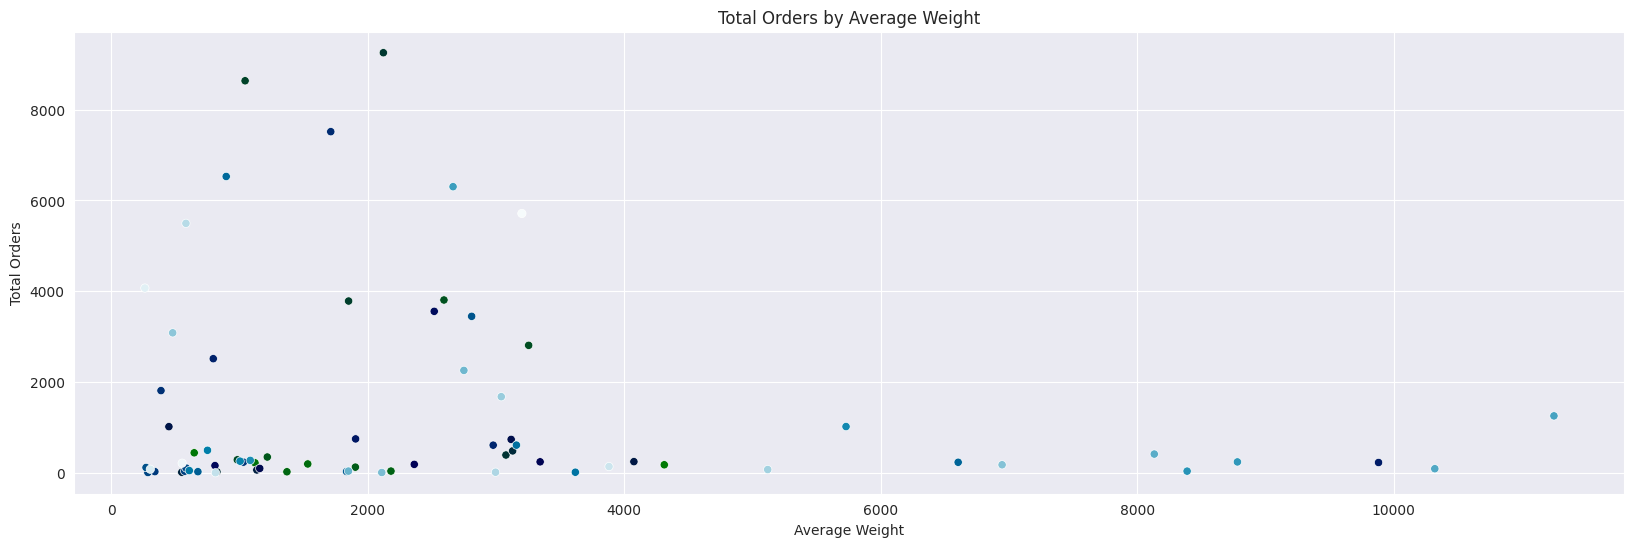

In [54]:
# plot total orders by average weight
plt.figure(figsize=(20, 6))
sns.scatterplot(x='average_weight', y='total_orders', data=products_analysis_df, hue='product_category_name', palette='ocean', legend=False)
plt.title('Total Orders by Average Weight')
plt.xlabel('Average Weight')
plt.ylabel('Total Orders')
plt.show()

High weight items tend to be ordered less often.

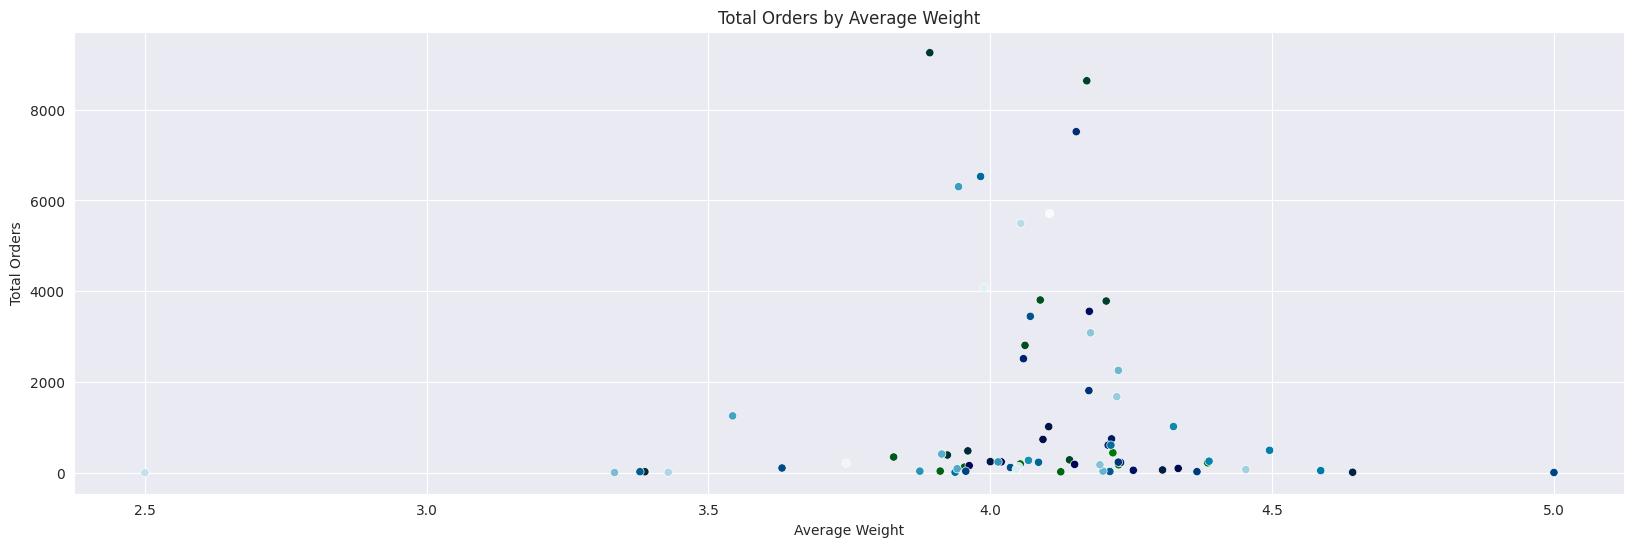

In [55]:
# plot total orders by average review score
plt.figure(figsize=(20, 6))   
sns.scatterplot(x='average_review_score', y='total_orders', data=products_analysis_df, hue='product_category_name', palette='ocean', legend=False)
plt.title('Total Orders by Average Weight')
plt.xlabel('Average Weight')
plt.ylabel('Total Orders')
plt.show()

# Task 3 - Sentimental Analysis of Reviews <a class="anchor" id="chapter3"></a>

In [ ]:
reviews_analysis_df = combined_filtered[[
    'order_id', 'order_status', 'order_purchase_timestamp',
    'order_delivered_customer_date',  'product_id', 'seller_id', 'shipping_limit_date',
    'price',  'product_category_name', 'product_height_cm', 'product_width_cm', 
    'seller_city', 'seller_state', 
    'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
    'customer_state', 'payment_type', 'review_id',
    'review_score', 'review_comment_title', 'review_comment_message',
    'review_creation_date', 'review_answer_timestamp'
]].copy()

In [ ]:
reviews_analysis_df_unnamed_products= combined[combined['order_id'].isin(orders_to_exclue)].copy()
reviews_analysis_df_unnamed_products = reviews_analysis_df_unnamed_products[[
    'order_id', 'order_status', 'order_purchase_timestamp',
    'order_delivered_customer_date',  'product_id', 'seller_id', 'shipping_limit_date',
    'price',  'product_category_name', 'product_height_cm', 'product_width_cm', 
    'seller_city', 'seller_state', 
    'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
    'customer_state', 'payment_type', 'review_id',
    'review_score', 'review_comment_title', 'review_comment_message',
    'review_creation_date', 'review_answer_timestamp'
]]

In [ ]:
reviews_analysis_df['review_comment_message'].values[100001]

'Comprei dia 19/08/18 com previsão de chegada dia 24/08/18. Até à data presente ( 01/09/18 ) não recebi o produto.'

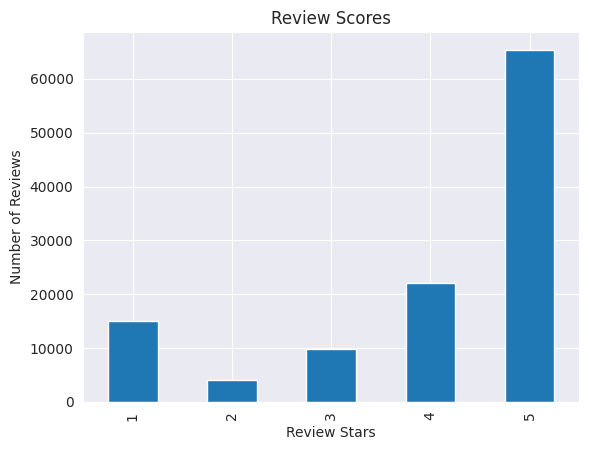

In [ ]:
ax = reviews_analysis_df['review_score'].value_counts().sort_index().plot(kind='bar', title='Review Scores')
ax.set_xlabel('Review Stars')
ax.set_ylabel('Number of Reviews')
plt.show()


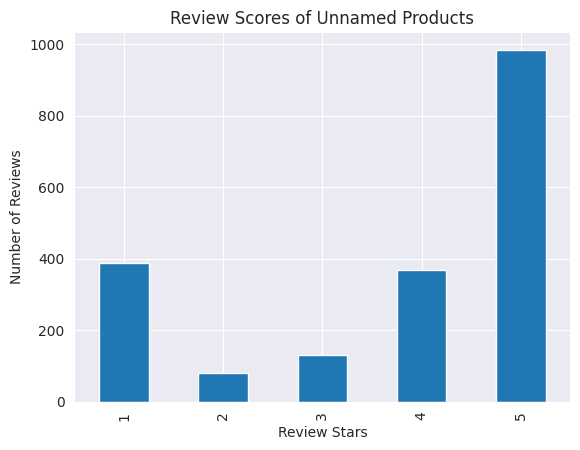

In [ ]:
ax = reviews_analysis_df_unnamed_products['review_score'].value_counts().sort_index().plot(kind='bar', title='Review Scores of Unnamed Products')
ax.set_xlabel('Review Stars')
ax.set_ylabel('Number of Reviews')
plt.show()

In [ ]:
percentage_of_negative_reviews = (reviews_analysis_df['review_score'] < 3).mean() * 100
percentage_of_negative_reviews_unnamed_products = (reviews_analysis_df_unnamed_products['review_score'] < 3).mean() * 100
print("Percentage of negative reviews: {:.2f}%".format(percentage_of_negative_reviews))
print("Percentage of negative reviews of unnamed products: {:.2f}%".format(percentage_of_negative_reviews_unnamed_products))

Percentage of negative reviews: 16.47%
Percentage of negative reviews of unnamed products: 23.94%


Percentage of negative reviews was significantly higher for unnamed products was significantly higher for unnamed products which means the theory about those products being fraudulent might be true.

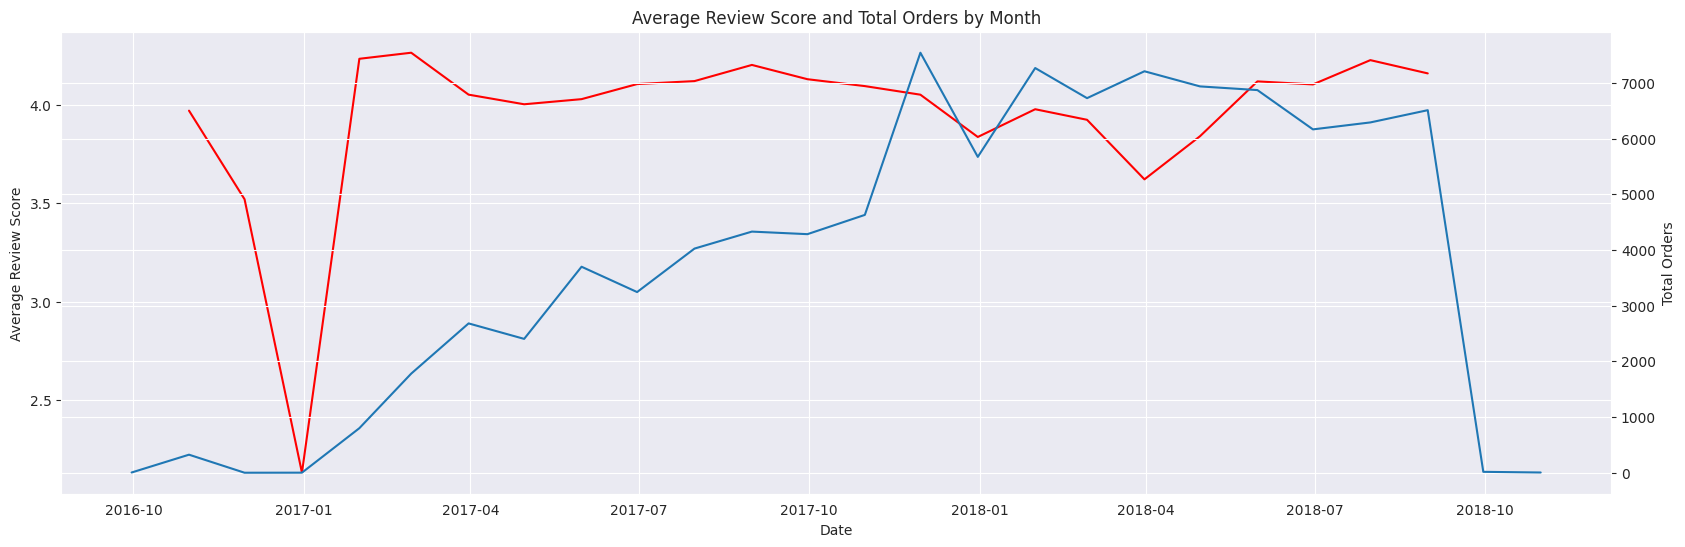

In [ ]:
# Plot average review score over time
reviews_analysis_df['review_creation_date'] = pd.to_datetime(reviews_analysis_df['review_creation_date'])
review_score_monthly = reviews_analysis_df.resample('M', on='review_creation_date')['review_score'].mean().reset_index()
monthly_orders = orders.resample('M', on='order_purchase_timestamp')['order_id'].count().reset_index()

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax.plot(review_score_monthly['review_creation_date'], review_score_monthly['review_score'], label='Average Review Score', color='red')
ax2 = plt.twinx()
ax2.plot(monthly_orders['order_purchase_timestamp'], monthly_orders['order_id'], label='Total Orders')
ax.set_xlabel('Date')
ax.set_ylabel('Average Review Score')
ax2.set_ylabel('Total Orders')
plt.title('Average Review Score and Total Orders by Month')
plt.show()


In [ ]:
# Filter for rows with reviews
reviews_analysis_df = reviews_analysis_df[~reviews_analysis_df['review_comment_message'].isna()]

In [ ]:
reviews = reviews_analysis_df['review_comment_message'].values[:1].tolist()
print(reviews)

['Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.']


In [ ]:
model_name = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

sentimental_analysis = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, return_all_scores=True)
sentimental_analysis(reviews[0])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'positive', 'score': 0.20170728862285614},
  {'label': 'neutral', 'score': 0.26437127590179443},
  {'label': 'negative', 'score': 0.5339214205741882}]]

In [ ]:
# this takes a long time to run so we are saving the results to a csv file to import on each next run
# reviews_analysis_df['review_sentiment'] = reviews_analysis_df['review_comment_message'].apply(lambda x: sentimental_analysis(x)[0])
# reviews_analysis_df.to_csv('reviews_analysis_df.csv', index=False)

reviews_analysis_df = pd.read_csv('reviews_analysis_df.csv')
print(type(reviews_analysis_df['review_sentiment'].values[0]))

<class 'str'>


In [ ]:
reviews_analysis_df['review_sentiment_dtype'] = reviews_analysis_df['review_sentiment'].apply(lambda x: type(x))
reviews_analysis_df = reviews_analysis_df[reviews_analysis_df['review_sentiment_dtype'] == str]

In [ ]:
def get_sentiment_score(x):
    data = ast.literal_eval(x)

    # Find the dictionary with the maximum score
    max_score_dict = max(data, key=lambda x: x['score'])

    # Extract the label with the highest score
    highest_label = max_score_dict['label']

    return highest_label

reviews_analysis_df['review_sentiment_label'] = reviews_analysis_df['review_sentiment'].apply(get_sentiment_score)

In [ ]:
print(reviews_analysis_df['review_sentiment_label'].value_counts())

review_sentiment_label
positive    28560
negative    17871
neutral      3324
Name: count, dtype: int64


Correlation between review score and sentiment score: 0.44512182072141276


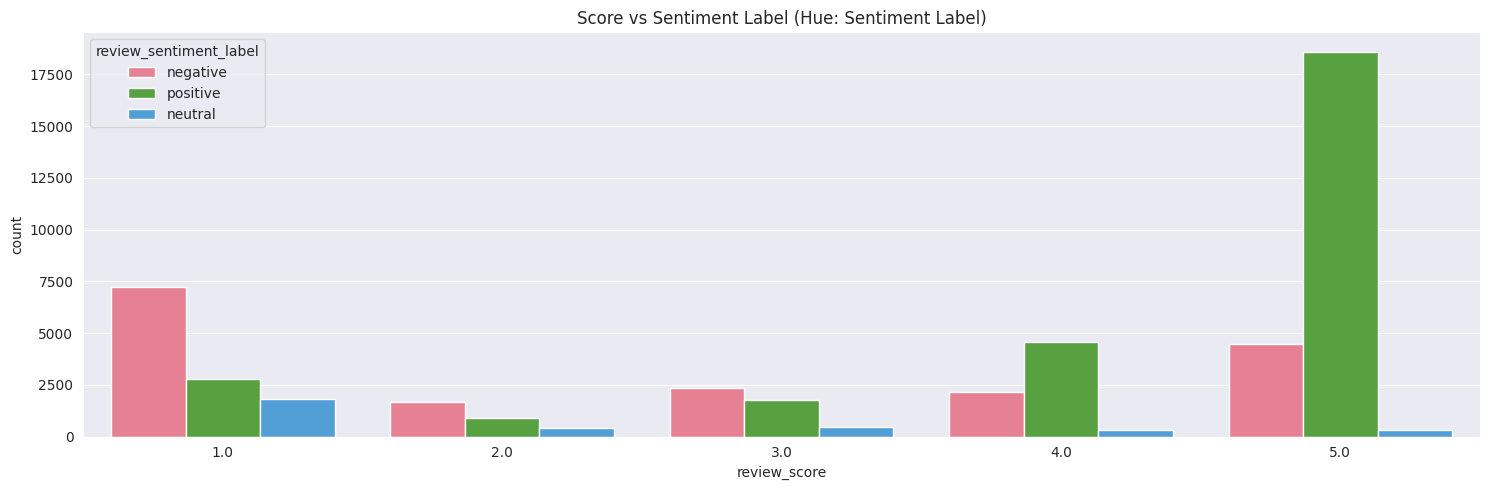

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

reviews_analysis_df['review_sentiment_score'] = reviews_analysis_df['review_sentiment_label'].apply(lambda x: 3 if x == 'positive' else (2 if x == 'neutral' else 1))

score_corr = reviews_analysis_df[['review_score', 'review_sentiment_score']].corr()
print(f"Correlation between review score and sentiment score: {score_corr['review_score']['review_sentiment_score']}")

plt.figure(figsize=(15, 5))

sns.countplot(x='review_score', hue='review_sentiment_label', data=reviews_analysis_df, palette='husl')
plt.title('Score vs Sentiment Label (Hue: Sentiment Label)')

plt.tight_layout()
plt.show()

The correlation between review scores and review sentiment is low at 45%.

# Task 1 - Demand Forecasting <a class="anchor" id="chapter4"></a>

## Statistical Forecasting with ARIMA <a class="anchor" id="section_4_1"></a>

                          order_id
order_purchase_timestamp          
2017-01-02                       0
2017-01-03                       0
2017-01-04                       0
2017-01-05                      32
2017-01-06                       8


<Axes: xlabel='order_purchase_timestamp'>

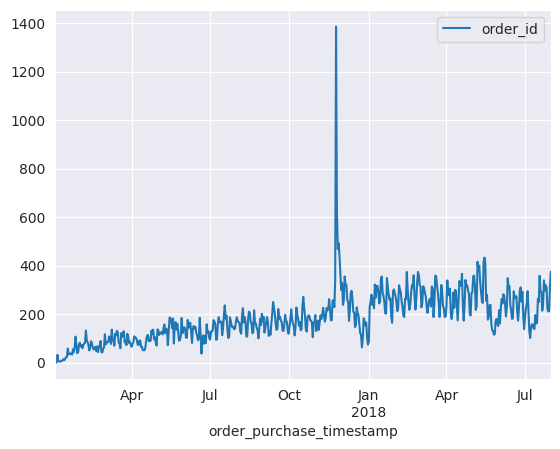

In [ ]:
orders_forecast = combined_filtered[combined_filtered['order_status'] == 'delivered'].copy()
orders_forecast = orders_forecast[[
    'order_id', 'order_purchase_timestamp', 'order_delivered_customer_date',
    'product_id', 'seller_id', 'price', 'product_category_name',
    'review_score', 'customer_unique_id', 'customer_zip_code_prefix'
]]

orders_armia = orders_forecast.resample('D', on='order_purchase_timestamp')['order_id'].count().reset_index()
orders_armia.set_index('order_purchase_timestamp', inplace=True)


# filter latest data as not all orders are delivered
orders_armia = orders_armia[orders_armia.index < '2018-08-01']

# filter old data which looks like the data is not complete
orders_armia = orders_armia[orders_armia.index > '2017-01-01']

print(orders_armia.head())
orders_armia.plot()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<Axes: xlabel='order_purchase_timestamp'>

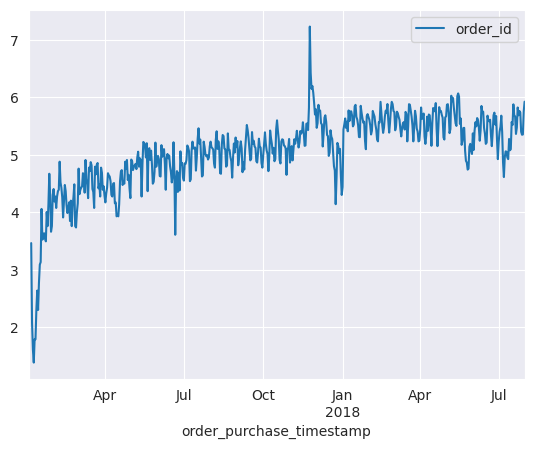

In [ ]:
orders_armia = np.log(orders_armia)
orders_armia.plot()

In [ ]:
train_arima = orders_armia['2018-07-01':'2018-07-14']
train_arima.reset_index()
test_arima = orders_armia['2018-07-15':'2018-07-21']
test_arima.reset_index()

,order_purchase_timestamp,order_id
0,2018-07-15,5.099866
1,2018-07-16,5.572154
2,2018-07-17,5.521461
3,2018-07-18,5.880533
4,2018-07-19,5.686975
5,2018-07-20,5.673323
6,2018-07-21,5.365976


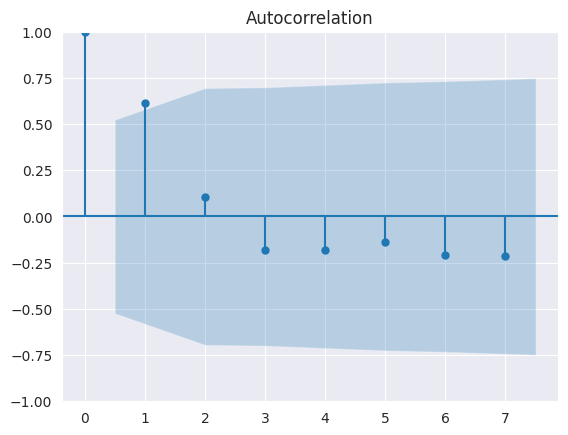

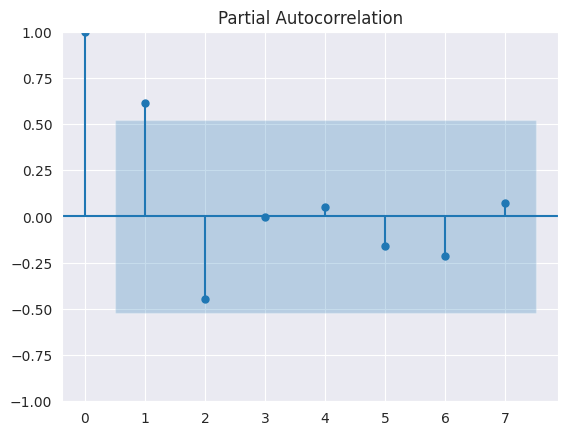

In [ ]:
# check for stationarity of time series
acf_plot = plot_acf(train_arima)

pacf_plot = plot_pacf(train_arima)

In [ ]:
adf_test = adfuller(train_arima)
print(f'p-value: {adf_test[1]}')
if adf_test[1] <= 0.05:
    print('The series is stationary')
else:
    print('The series is not stationary')

p-value: 0.006748045787694727
The series is stationary


In [ ]:
model = ARIMA(train_arima, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               order_id   No. Observations:                   14
Model:                 ARIMA(2, 1, 0)   Log Likelihood                   1.150
Date:                Fri, 03 May 2024   AIC                              3.700
Time:                        13:31:22   BIC                              5.395
Sample:                    07-01-2018   HQIC                             3.351
                         - 07-14-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2881      0.230      1.251      0.211      -0.163       0.740
ar.L2         -0.4493      0.332     -1.355      0.175      -1.099       0.201
sigma2         0.0472      0.032      1.469      0.1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


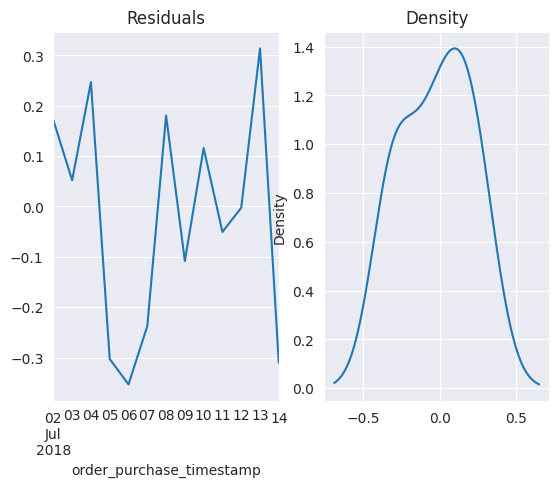

In [ ]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

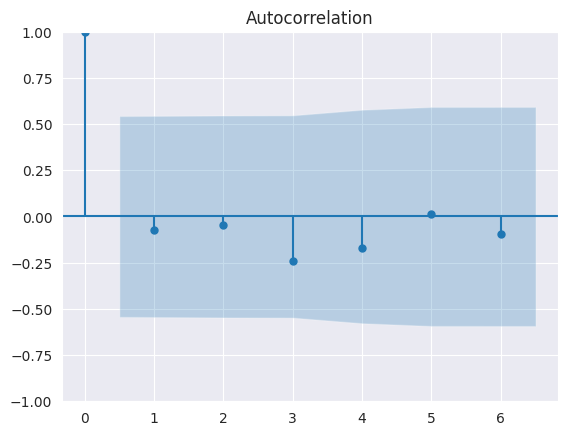

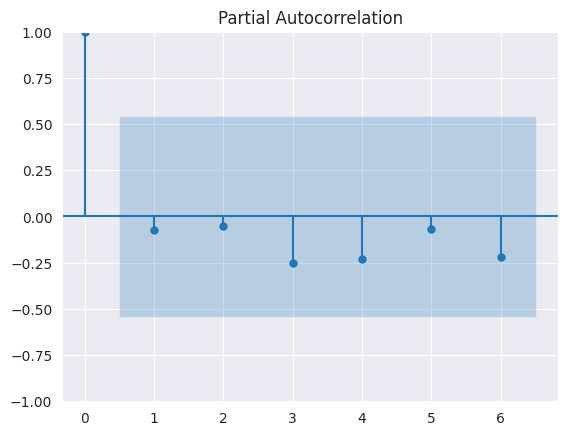

In [ ]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

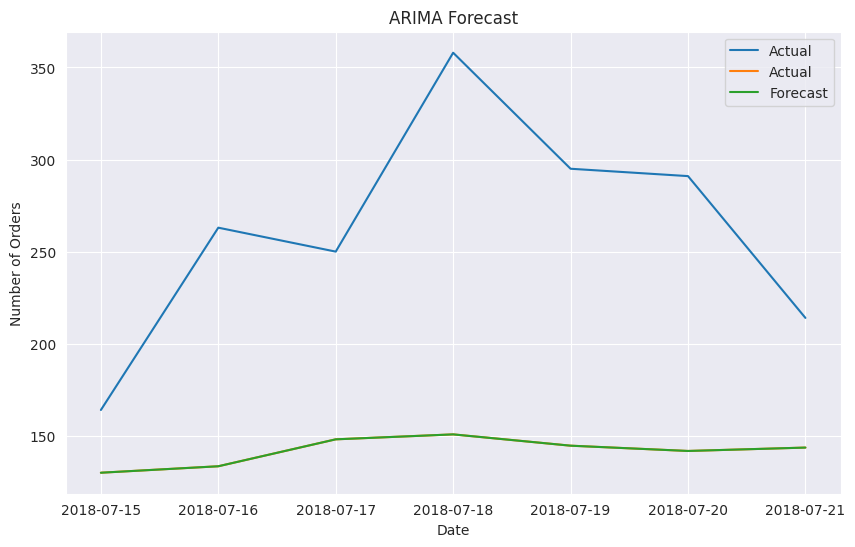

In [ ]:
# Forecasting
forecast = model_fit.forecast(steps=len(test_arima))
forecast = np.exp(forecast)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(test_arima.index, np.exp(test_arima), label='Actual')
plt.plot(test_arima.index, forecast, label='Forecast')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()


In [ ]:
mae = mean_absolute_error(test_arima, forecast_test)
mape = mean_absolute_percentage_error(test_arima, forecast_test)
rmse = np.sqrt(mean_squared_error(test_arima, forecast_test))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

mae: 0.5901345110624876
mape: 0.10511626980683407
rmse: 0.6235189873282718


## Forecasting with XGBoost

In [ ]:
xg_forecast = orders_forecast.resample('D', on='order_purchase_timestamp')['order_id'].count().reset_index()

xg_forecast['order_purchase_timestamp'] = pd.to_datetime(xg_forecast['order_purchase_timestamp'])
xg_forecast.set_index('order_purchase_timestamp', inplace=True)

In [ ]:
xg_forecast['weekday'] = xg_forecast.index.weekday
xg_forecast['month'] = xg_forecast.index.month
xg_forecast['day'] = xg_forecast.index.day
xg_forecast['dayofyear'] = xg_forecast.index.dayofyear
xg_forecast['quarter'] = xg_forecast.index.quarter
xg_forecast['year'] = xg_forecast.index.year

xg_forecast.head()

,order_id,weekday,month,day,dayofyear,quarter,year
order_purchase_timestamp,,,,,,,
2016-10-03,7,0,10,3,277,4,2016
2016-10-04,69,1,10,4,278,4,2016
2016-10-05,51,2,10,5,279,4,2016
2016-10-06,47,3,10,6,280,4,2016
2016-10-07,45,4,10,7,281,4,2016


In [ ]:
train_df = xg_forecast['2018-07-07':'2018-07-21']
test_df = xg_forecast['2018-07-22':'2018-07-28']

X_train = train_df.drop('order_id', axis=1)
y_train = train_df['order_id']

X_test = test_df.drop('order_id', axis=1)
y_test = test_df['order_id']

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stoping = 50)
reg.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:71.75513
[1]	validation_0-rmse:62.75723
[2]	validation_0-rmse:57.02967
[3]	validation_0-rmse:53.58448
[4]	validation_0-rmse:50.91572
[5]	validation_0-rmse:49.09243
[6]	validation_0-rmse:47.75427
[7]	validation_0-rmse:47.05205
[8]	validation_0-rmse:46.43188
[9]	validation_0-rmse:46.09574
[10]	validation_0-rmse:45.90043
[11]	validation_0-rmse:45.80058
[12]	validation_0-rmse:45.76385
[13]	validation_0-rmse:45.76752
[14]	validation_0-rmse:45.79583
[15]	validation_0-rmse:45.83808
[16]	validation_0-rmse:45.88708
[17]	validation_0-rmse:45.93816
[18]	validation_0-rmse:45.98837
[19]	validation_0-rmse:46.03595
[20]	validation_0-rmse:46.07990
[21]	validation_0-rmse:46.11980
[22]	validation_0-rmse:46.15555
[23]	validation_0-rmse:46.18725
[24]	validation_0-rmse:46.21515
[25]	validation_0-rmse:46.23954
[26]	validation_0-rmse:46.26078
[27]	validation_0-rmse:46.27919
[28]	validation_0-rmse:46.29509
[29]	validation_0-rmse:46.30879
[30]	validation_0-rmse:46.32057
[31]	validation_0-

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:08:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stoping" } are not used.

  warnings.warn(smsg, UserWarning)


[237]	validation_0-rmse:46.38894
[238]	validation_0-rmse:46.38894
[239]	validation_0-rmse:46.38894
[240]	validation_0-rmse:46.38894
[241]	validation_0-rmse:46.38894
[242]	validation_0-rmse:46.38894
[243]	validation_0-rmse:46.38894
[244]	validation_0-rmse:46.38894
[245]	validation_0-rmse:46.38894
[246]	validation_0-rmse:46.38894
[247]	validation_0-rmse:46.38894
[248]	validation_0-rmse:46.38894
[249]	validation_0-rmse:46.38894
[250]	validation_0-rmse:46.38894
[251]	validation_0-rmse:46.38894
[252]	validation_0-rmse:46.38894
[253]	validation_0-rmse:46.38894
[254]	validation_0-rmse:46.38894
[255]	validation_0-rmse:46.38894
[256]	validation_0-rmse:46.38894
[257]	validation_0-rmse:46.38894
[258]	validation_0-rmse:46.38894
[259]	validation_0-rmse:46.38894
[260]	validation_0-rmse:46.38894
[261]	validation_0-rmse:46.38894
[262]	validation_0-rmse:46.38894
[263]	validation_0-rmse:46.38894
[264]	validation_0-rmse:46.38894
[265]	validation_0-rmse:46.38894
[266]	validation_0-rmse:46.38894
[267]	vali

[639]	validation_0-rmse:46.38894
[640]	validation_0-rmse:46.38894
[641]	validation_0-rmse:46.38894
[642]	validation_0-rmse:46.38894
[643]	validation_0-rmse:46.38894
[644]	validation_0-rmse:46.38894
[645]	validation_0-rmse:46.38894
[646]	validation_0-rmse:46.38894
[647]	validation_0-rmse:46.38894
[648]	validation_0-rmse:46.38894
[649]	validation_0-rmse:46.38894
[650]	validation_0-rmse:46.38894
[651]	validation_0-rmse:46.38894
[652]	validation_0-rmse:46.38894
[653]	validation_0-rmse:46.38894
[654]	validation_0-rmse:46.38894
[655]	validation_0-rmse:46.38894
[656]	validation_0-rmse:46.38894
[657]	validation_0-rmse:46.38894
[658]	validation_0-rmse:46.38894
[659]	validation_0-rmse:46.38894
[660]	validation_0-rmse:46.38894
[661]	validation_0-rmse:46.38894
[662]	validation_0-rmse:46.38894
[663]	validation_0-rmse:46.38894
[664]	validation_0-rmse:46.38894
[665]	validation_0-rmse:46.38894
[666]	validation_0-rmse:46.38894
[667]	validation_0-rmse:46.38894
[668]	validation_0-rmse:46.38894
[669]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stoping=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

<Axes: title={'center': 'Feature Importance'}>

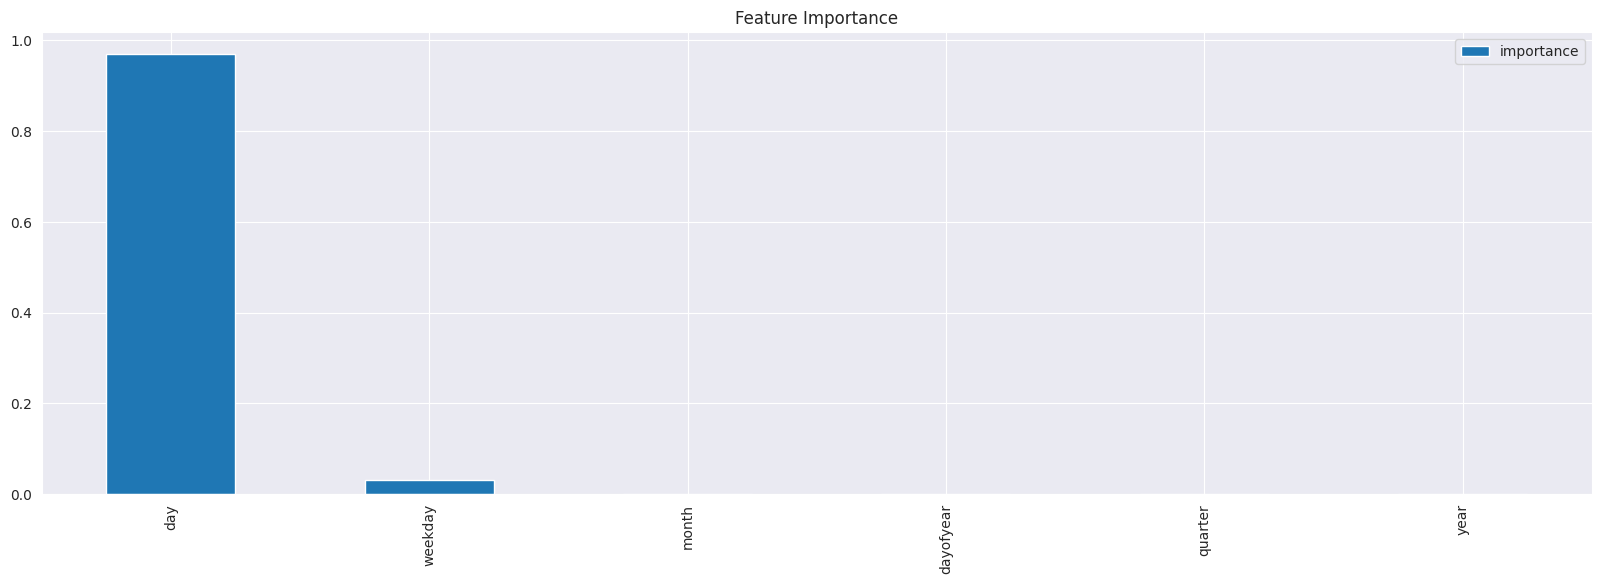

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_, index=X_train.columns, columns=['importance'])
fi.sort_values(by='importance', ascending=False, inplace=True)
fi.plot(kind='bar', title='Feature Importance', figsize=(20, 6))

/tmp/ipykernel_2493/1295406846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = reg.predict(X_test)


<Axes: title={'center': 'XGBoost Forecast'}, xlabel='order_purchase_timestamp'>

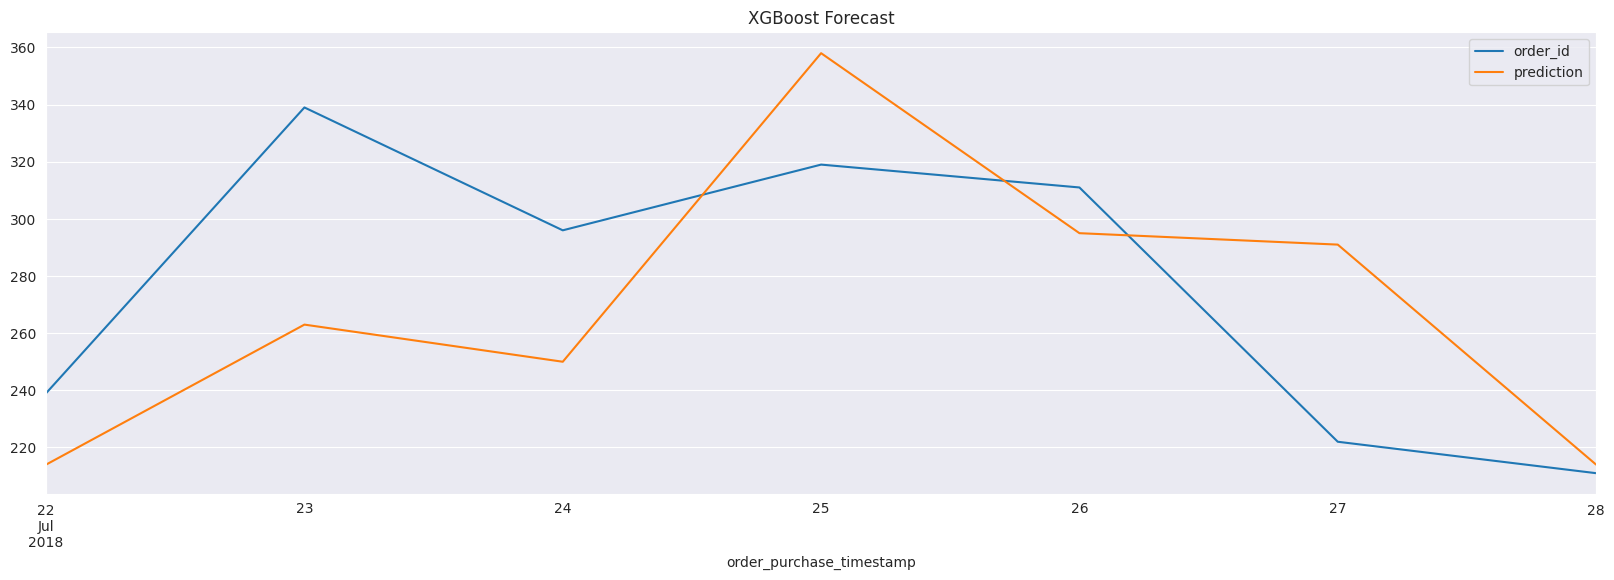

In [ ]:
test_df['prediction'] = reg.predict(X_test)
test_df.plot(y=['order_id', 'prediction'], title='XGBoost Forecast', figsize=(20, 6))